In [1]:
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from scipy.io import wavfile
import os
import serial

def read_arduino(ser,inputBufferSize):
#     data = ser.readline((inputBufferSize+1)*2)
    data = ser.read((inputBufferSize+1)*2)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return np.flip(np.array(result)-512)


# ser.read works by waiting for <inputBufferSize> bytes from the port

def read_arduinbro(wav_array, inputBufferSize, k):
#    data = ser.readline(inputBufferSize)
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)




def load_training_data(path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow"]):


    files = os.listdir(path)

    waves = {}
    labels = {}

    for file in files:
        filters = [x not in file.lower() for x in blacklist]
        if (("right" in file.lower() or "left" in file.lower()) and 
            np.all(np.array(filters))):
            if file[-4::] == ".wav":
                samprate, wav_array = wavfile.read(path+file)

                wav_array = wav_array*scale_factor


                waves[file[:-4]] = wav_array
            elif file[-4::] == ".txt":
                labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
                labels_dat.columns = ["label", "time"]
                # Change depending on whether L is coded as 1 or as 2
                labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]

                labels[file[:-4].replace(".", "")] = labels_dat


    print(waves.keys(), labels.keys())

    assert set(waves.keys()).difference(set(labels.keys())) == set()
    
    return waves, labels, samprate
    

In [2]:
def three_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    # Appended indices
    max_min_locs = np.append(max_locs, min_locs)
    
    # Values of above indices
    max_min_values = filtered_arr[max_min_locs]
    
    # Absolute value of those values
    abs_max_min_values = np.abs(max_min_values)
    
    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)
    # A vector with a length equal to the number of maximums: all '1' to say maximum
    numMax = [1]*len(max_locs)
    
    # Vector same size as max_min_values with first half being maximums and second half being minimums
    isMin = np.append(numMax, numMin)
    
    # Stack the three vectors
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]

    classificationFound = False
    
    # We will continue looping until we have an appropriate classification. This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    while not classificationFound and loops < max_loops:
        
        # Take the top three magnitudes
        top_3 = val_and_idx_sorted[:, 0:3]
        
        # Sort according to the indices of those values
        top_3_sorted = top_3[ :, top_3[1].argsort()]
        
        # Break if we run out of turning points
        if top_3_sorted.shape != (3, 3):
            return "_"
        
        # If two min or two max occur one after the other, we know we have an inappropriate result so we delete one of those doubled min/max
        if top_3_sorted[2, 0]*top_3_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        elif top_3_sorted[2, 1]*top_3_sorted[2, 2] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 2, 1)
        else:
            classificationFound = True
        
        loops += 1
    
    if np.sum(top_3_sorted[2, :]) == -1:
        return 'L'
    elif np.sum(top_3_sorted[2, :]) == 1:
        return 'R'
    else:
        return "_"

In [3]:
def two_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)
#     plt.plot(filtered_arr)
#     plt.plot(arr)
    
    # 512 is the x axis
    filtered_arr = filtered_arr - 512

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    # Appended indices
    max_min_locs = np.append(max_locs, min_locs)
    
    # Values of above indices
    max_min_values = filtered_arr[max_min_locs]
    
    # Absolute value of those values
    abs_max_min_values = np.abs(max_min_values)
    
    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)
    # A vector with a length equal to the number of maximums: all '1' to say maximum
    numMax = [1]*len(max_locs)
    
    # Vector same size as max_min_values with first half being maximums and second half being minimums
    isMin = np.append(numMax, numMin)
    
    # Stack the three vectors
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
#     print(val_and_idx_sorted)

    classificationFound = False
    
    # We will continue looping until we have an appropriate classification. This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    while not classificationFound and loops < max_loops:
        
        # Take the top two magnitudes
        top_2 = val_and_idx_sorted[:, 0:2]
        
        
        # Sort according to the indices of those values
        top_2_sorted = top_2[ :, top_2[1].argsort()]
#         print(top_2)
#         print(top_2_sorted)
        
        # Break if we run out of turning points
        if top_2_sorted.shape != (3, 2):
            return "_"
        
        # If two min or two max occur one after the other, we know we have an inappropriate result so we delete one of those doubled min/max
        if top_2_sorted[2, 0]*top_2_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        else:
            classificationFound = True
        
        loops += 1
    
    
    if top_2_sorted[2, 0] > 0:
        return 'L'
    elif top_2_sorted[2, 0] < 0:
        return 'R'
    else:
        return "_"

In [14]:
def streaming_classifier(
    wav_array, # Either the array from file (or ser if live = True)
    samprate,
    classifier = three_pronged_smoothing_classifier, 
    using_zeroes_classifier = False,            
    plot_zeroes_classifier = False,                # Plot the waves that took an unusually long time for the zeroes classifier
    use_smart_hyp_zeroes_height_threshold = False,      # Whether or not you use the smart threshold as the height threshold for the zeroes classifier
    zeroes_height_threshold = 10,                  # Only used if using_zeroes_classifier is true
    zeroes_consec_threshold = 0.2,                 # Only used if using_zeroes_classifier is true
    window_size = 1.5, # Total detection window [s]
    N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
    hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off end of the window in order to define the middle portion
    hyp_detection_buffer_start = 0.7, # seconds - how much time to shave off start of the window in order to define the middle portion
    hyp_event_smart_threshold_window = 0, # The length of the calibration period to define the threshold
    hyp_calibration_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the calibration statistic
    hyp_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
    hyp_event_smart_threshold_factor = 0.5, # The scale factor of the calibration range that will become the threshold
    hyp_event_history = 5, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
    hyp_consecutive_triggers = 3, # How many threshold triggers need to occur in a row for an event to be called
    hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
    hyp_timeout = 10,
    total_time = None,  # max time. If none, it goes forever!
    plot = True, # Whether to plot the livestream data
    store_events = False, # Whether to return the classification window array for debugging purposes
    store_times = False,        # Store time taken for each classification
    nil_classifier = False,     # Does not classify, just gives L as its prediction always. Used for time complexity purposes.
    verbose=False, # lol
    live = True, # Whether we're live
    timeout = False):
#     plt.plot(wav_array)
    
    ### Initialisation ###
    
    if total_time is None:
        try:
            total_time = len(wav_array)/samprate
        except:
            total_time = 1000000 # Just a large number
    if store_events:
        predictions_storage = []
    
    predictions = ""
    predictions_timestamps = []

    
    # Initialise variables
    inputBufferSize = int(window_size/N_loops_over_window * samprate)
    N_loops =(total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
    T_acquire = inputBufferSize/samprate    # length of time that data is acquired for 
    N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window


    # Initialise plot
    if plot:
        min_y = -200 #np.min(wav_array)
        max_y = 200 #np.max(wav_array)
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        plt.ion()
        fig.show()
        fig.canvas.draw()


    # Hyperparameter conversions
    hyp_detection_buffer_start_ind = int(round(hyp_detection_buffer_start * samprate))
    hyp_detection_buffer_end_ind = int(round(hyp_detection_buffer_end * samprate))
    
    
    # Initialise Calibration
    calibrate = False
    N_loops_calibration = hyp_event_smart_threshold_window//(window_size/N_loops_over_window)
    

    # Initialise Event History
    event_history = np.array([False]*hyp_event_history)
    primed = True

    
    ### Start stream ###
    classification_times = []
    for k in range(0,int(N_loops)):
        
        if live:
            data = read_arduino(wav_array,inputBufferSize)
            data_temp = process_data(data)
        else:
            data_temp = read_arduinbro(wav_array, inputBufferSize, k)


        if k < N_loops_over_window:
            if k==0:
                data_cal = data_temp
                data_plot = data_temp
            else:
                data_plot = np.append(data_temp, data_plot)
                if calibrate:
                    data_cal = np.append(data_temp, data_cal)
            continue
        else:
            data_plot = np.roll(data_plot,len(data_temp))
            data_plot[0:len(data_temp)] = data_temp
            
            if calibrate:
                data_cal = np.append(data_temp,data_cal)

                if (k > N_loops_calibration):
                    st_range = hyp_calibration_statistic_function(data_cal)
                    hyp_event_threshold = st_range*hyp_event_smart_threshold_factor
                    # with open("./print.txt", "a") as file:
                    #     file.write(str(hyp_event_threshold)+',')
                    calibrate = False
                continue


        ### CLASSIFIER ###
        
        # Event Detection
        interval = data_plot[hyp_detection_buffer_start_ind:-hyp_detection_buffer_end_ind] # Take middle part of window
        test_stat = hyp_test_statistic_function(interval) # Calculate test stat (defaults to range) 
        hyp_event_threshold = 100 # FIXXXXX
        is_event = (test_stat > hyp_event_threshold) # Test threshold

        # Record History
        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event


        # Pass window to classifier
        if np.all(event_history[0:hyp_consecutive_triggers]) and primed:
            if store_times:
                if nil_classifier:
                    start = time.time_ns()
                    prediction = 'L'
                    end = time.time_ns()
                    time_taken = end - start
                    classification_times.append(time_taken)
                else:
                    if using_zeroes_classifier:
                        if use_smart_hyp_zeroes_height_threshold:
                            start = time.time_ns()
                            prediction = classifier(data_plot, samprate, consec_seconds = zeroes_consec_threshold, ave_height = hyp_event_threshold)
                            end = time.time_ns()
                            time_taken = end - start
                            classification_times.append(time_taken)
                            if plot_zeroes_classifier and time_taken > 998800: 
                                plt.figure()
                                plt.plot(data_plot)

                        else:
                            start = time.time_ns()
                            prediction = classifier(data_plot, samprate, consec_seconds = zeroes_consec_threshold, ave_height = zeroes_height_threshold)
                            end = time.time_ns()
                            time_taken = end - start
                            classification_times.append(time_taken)
                            if plot_zeroes_classifier and time_taken > 50000: 
                                plt.figure()
                                plt.plot(data_plot)
                    else:
                        start = time.time_ns()
                        prediction = classifier(data_plot, samprate)
                        end = time.time_ns()
                        time_taken = end - start
                        classification_times.append(time_taken)
            else:
                if nil_classifier:
                    prediction = 'L'
                else:
                    if using_zeroes_classifier:
                        if use_smart_hyp_zeroes_height_threshold:
                            prediction = classifier(data_plot, samprate, consec_seconds = zeroes_consec_threshold, ave_height = hyp_event_threshold)
                        else:
                            prediction = classifier(data_plot, samprate, consec_seconds = zeroes_consec_threshold, ave_height = zeroes_height_threshold)
                    else:
                        prediction = classifier(data_plot, samprate)
            predictions += prediction
            
            print(f"CONGRATULATIONS, ITS AN {prediction}!") if verbose else None

            if store_events:
                predictions_storage.append(data_plot)
            
            # Record time interval of event
            end_time = round(k*inputBufferSize/samprate, 2)
            start_time = round(end_time - window_size, 2)
            predictions_timestamps.append((start_time, end_time))
            
            timer = hyp_timeout

            primed = False
        
        if not timeout:
            if np.all(~event_history[0:hyp_consecutive_reset]):
                primed = True
        else:
            timer -= 1
            if timer < 0:
                primed = True


        ## PLOT ##

        if plot:
            t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
            ax1.clear()
            # Debugging Annotations
            if np.all(event_history[0:hyp_consecutive_triggers]) and timer >0:
                ax1.annotate(f"ITS AN {prediction}!!!", (window_size/2, max_y-50))
            
            ax1.annotate(f"{event_history}", (window_size/2, max_y-70))
            ax1.set_xlim(0, window_size)
            ax1.set_ylim(min_y, max_y)
            plt.xlabel('time [s]')
            ax1.plot(t,data_plot)
            fig.canvas.draw()    
            plt.show()
    
    if store_events and store_times:
        return predictions, predictions_timestamps, predictions_storage, classification_times
    elif store_events:
        return predictions, predictions_timestamps, predictions_storage
    elif store_times:
        return predictions, predictions_timestamps, classification_times
    else:
        return predictions, predictions_timestamps

In [15]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.URT0 - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.iPhone-WirelessiAPv2 - n/a
/dev/cu.usbserial-DJ00E328 - FT231X USB UART - FT231X USB UART


In [16]:
# Read example data
baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
cport = "/dev/cu.usbserial-DJ00E328"
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/20000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)
data = read_arduino(ser,inputBufferSize)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


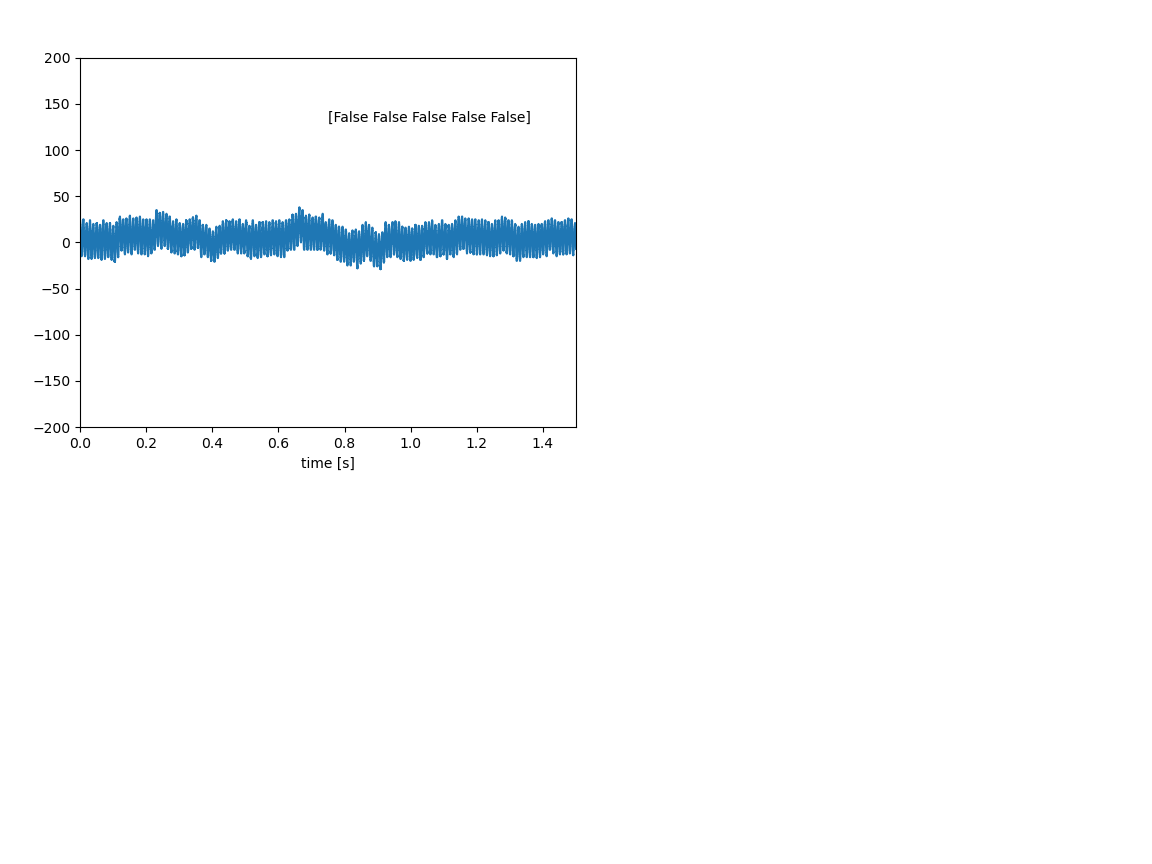

KeyboardInterrupt: 

In [17]:

from scipy.io.wavfile import read

# wav_fname = "left-right-1.wav"
# samprate, data = read(wav_fname)
%matplotlib notebook
samprate = 20000
streaming_classifier(ser, samprate)

<IPython.core.display.Javascript object>


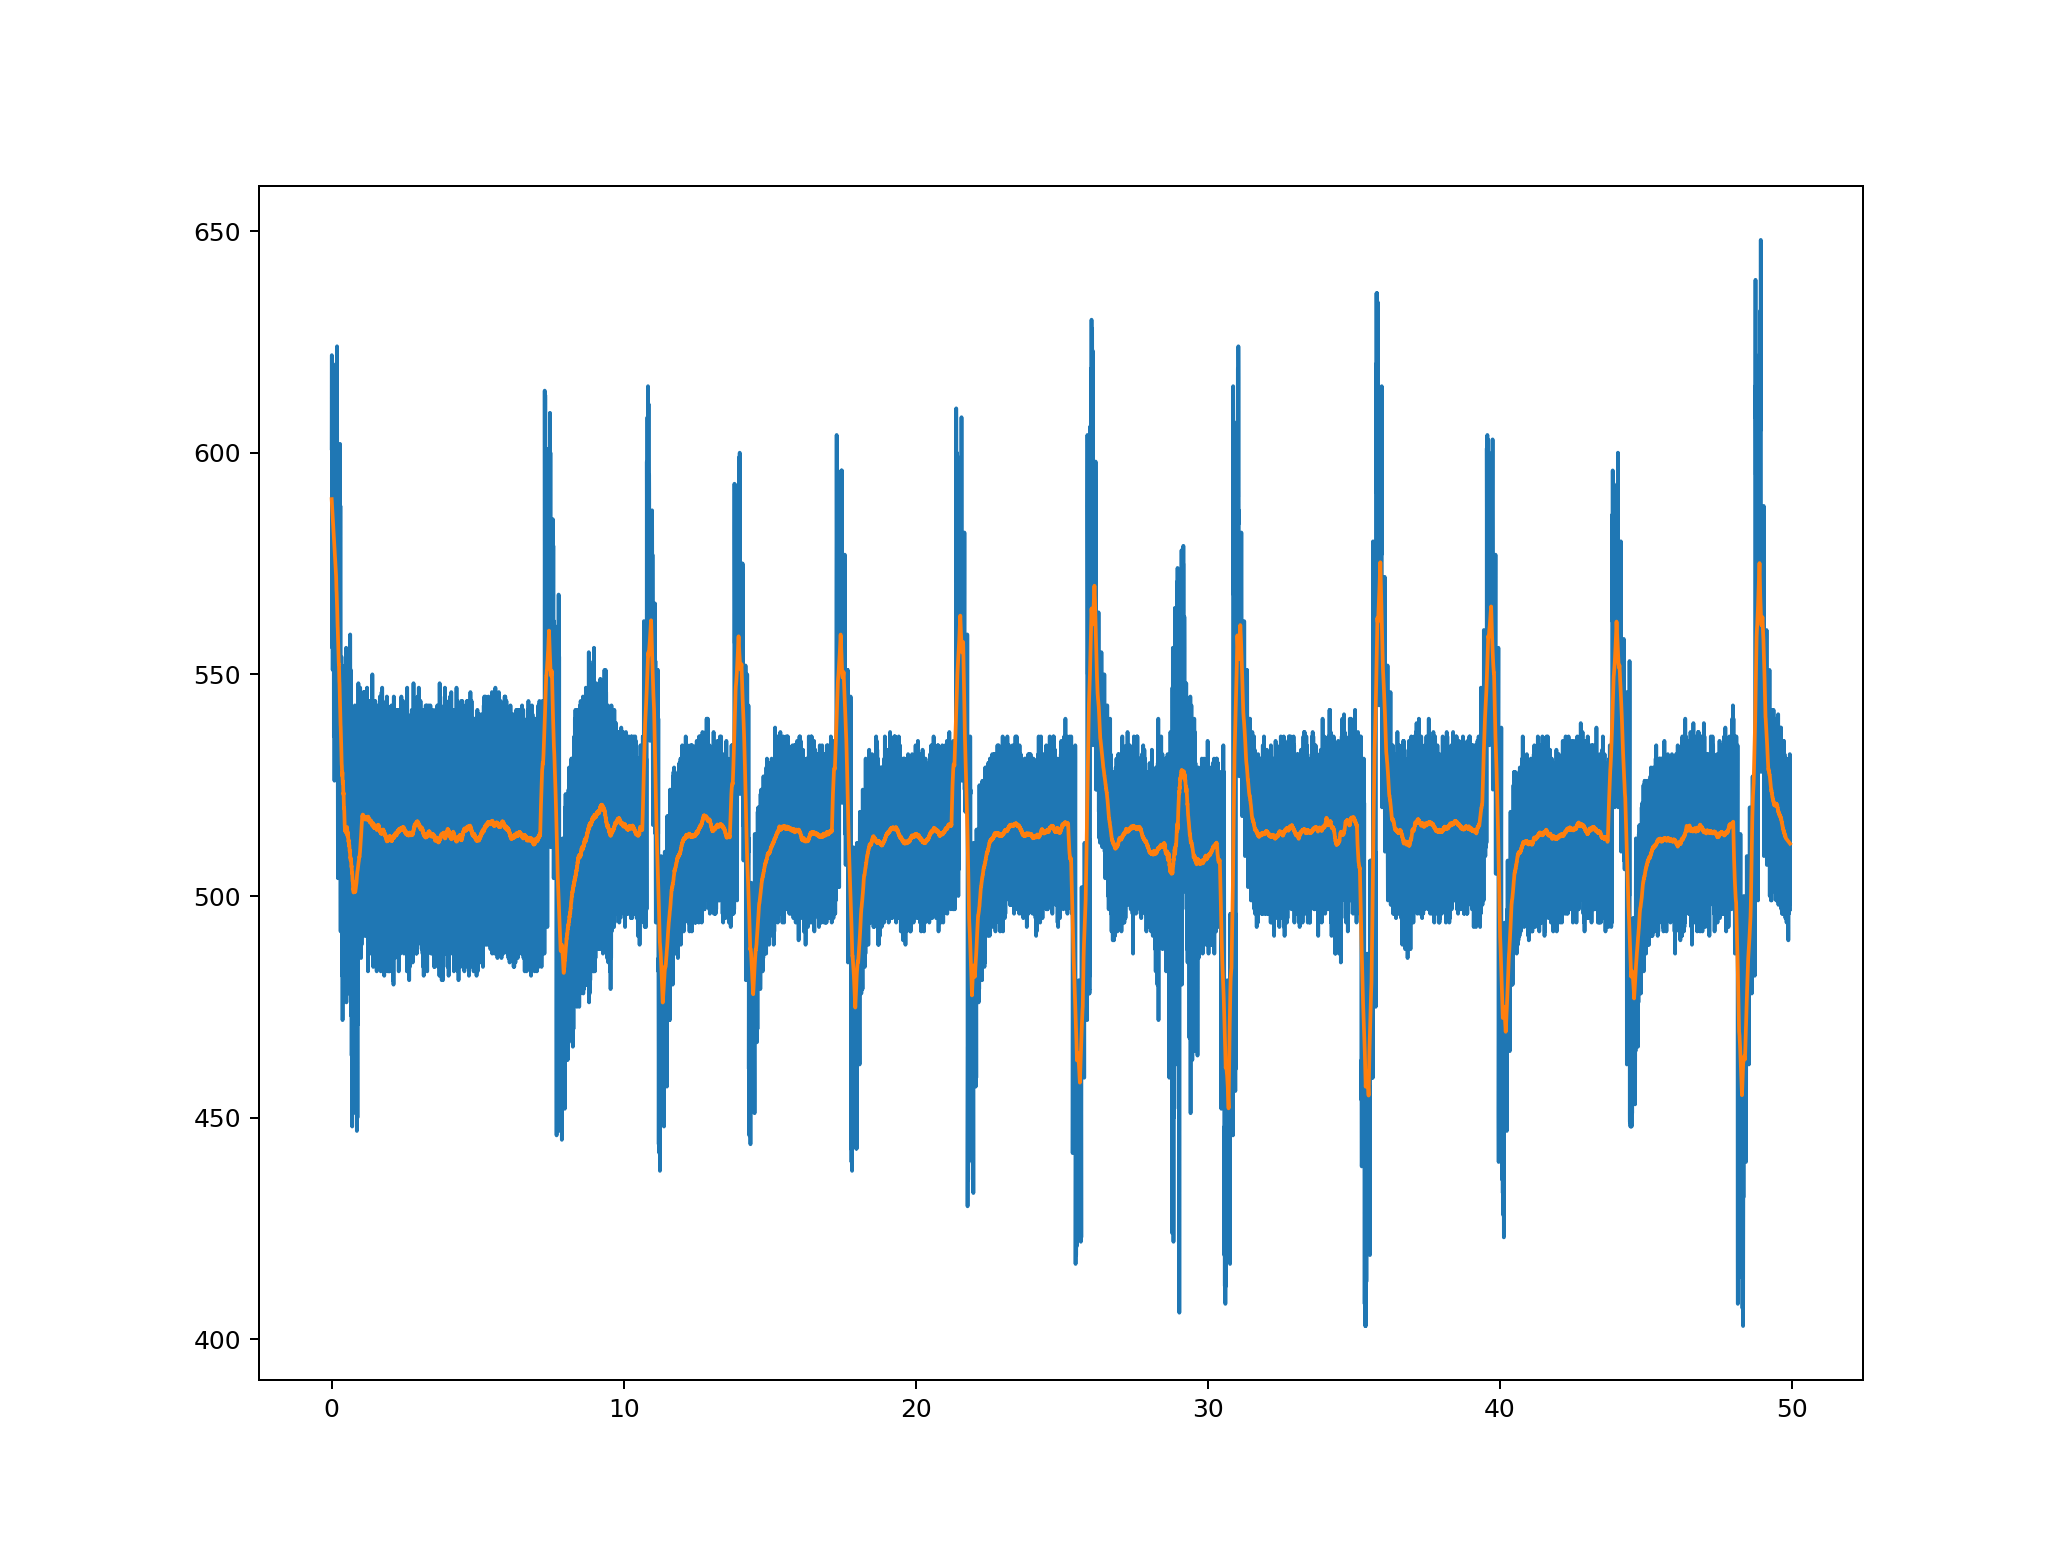

In [5]:
# from scipy import signal
# import numpy as np
# import matplotlib.pyplot as plt
# import time
# from scipy.io.wavfile import read

# wav_fname = "l-r-sandeep1.wav"
# samprate, data = read(wav_fname)

# # arr_ds = arr[0::downsample_rate]

# # %matplotlib notebook
# # plt.plot(data)

# samprate = 10000.0
# downsample_rate=10
# window_size_seconds=0.3
# data = data[0::downsample_rate]

# fs = samprate/downsample_rate;
# dt = 1/fs
# t = np.arange(0, (len(data)*dt), dt)

# # Smooth wave
# window_length = int(window_size_seconds*samprate/downsample_rate + 1)
# filtered_arr = signal.savgol_filter(data, window_length, 1)
# %matplotlib notebook
# plt.plot(t, data)
# plt.plot(t, filtered_arr)
    

# # # Smooth wave
# # window_length = int(window_size_seconds*samprate/downsample_rate + 1)
# # filtered_arr = signal.savgol_filter(data, window_length, 1)

# # %matplotlib notebook
# # plt.plot(filtered_arr)